# Bi directional LSTM Model
---

# 1. Import required libs

In [1]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

---

# 2. Load and visualise Data

## 2.1. Load dataset

In [2]:
ticker = "MSFT"
month = "1"
path = f"../TDL_Project_Data/{ticker}_year1_month{month}.csv"
stock = pd.read_csv(path, parse_dates=['time'])

In [3]:
stock.head()

,time,open,high,low,close,volume,company,price_1_min_ahead,price_2_min_ahead,price_3_min_ahead,...,EMA,MACD,MACD_Signal,change,gain,loss,avg_gain,avg_loss,rs,RSI
0,2021-04-23 15:53:00,260.93,261.11,260.890,261.0000,105102,MSFT,260.93,261.18,261.05,...,261.146603,-0.133621,-0.145338,0.0700,0.07,0.0000,0.029490,0.063490,0.464483,31.716498
1,2021-04-23 15:52:00,260.81,260.98,260.810,260.9100,82132,MSFT,261.00,260.93,261.18,...,261.124069,-0.136377,-0.143545,-0.0900,0.00,0.0900,0.028015,0.064815,0.432235,30.179035
2,2021-04-23 15:51:00,261.05,261.17,260.800,260.8000,136199,MSFT,260.91,261.00,260.93,...,261.093205,-0.145757,-0.143988,-0.1100,0.00,0.1100,0.026615,0.067075,0.396792,28.407387
3,2021-04-23 15:50:00,261.01,261.09,261.005,261.0400,50257,MSFT,260.80,260.91,261.00,...,261.088138,-0.132300,-0.141650,0.2400,0.24,0.0000,0.037284,0.063721,0.585113,36.913021
4,2021-04-23 15:49:00,261.02,261.08,260.990,260.9946,56559,MSFT,261.04,260.80,260.91,...,261.079230,-0.123870,-0.138094,-0.0454,0.00,0.0454,0.035420,0.062805,0.563965,36.059951


## 2.2. Close price of stock along with bollinger bands and volume

No handles with labels found to put in legend.


Text(0.5, 1.0, '')

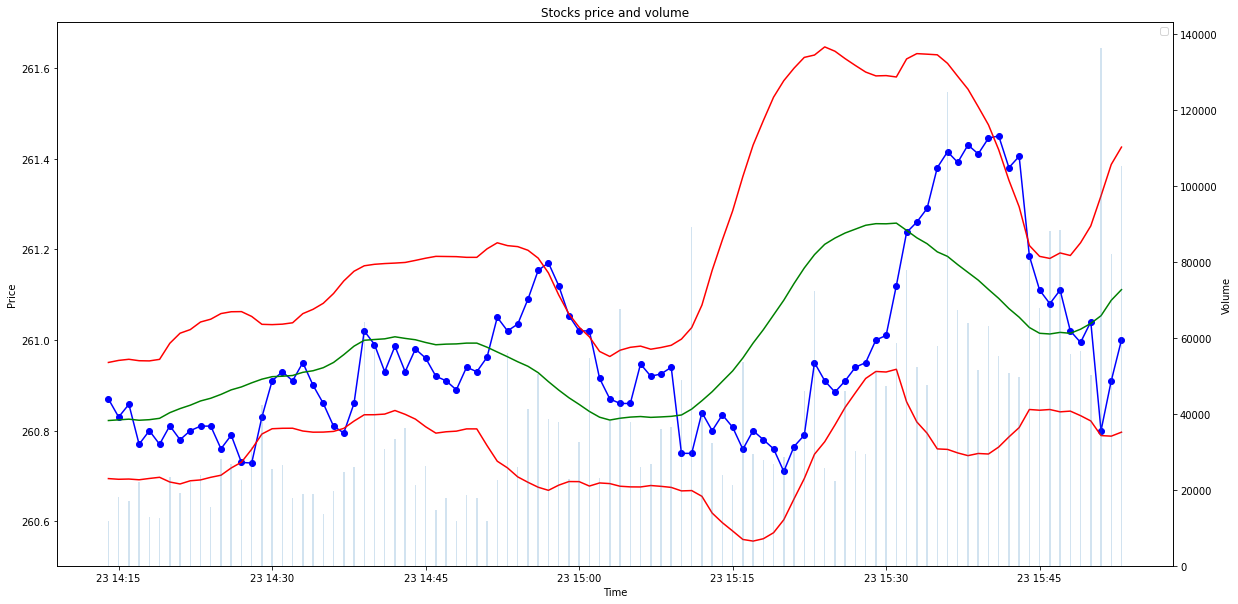

In [4]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')
ax1.plot(stock['time'][:100], stock['SMA'][:100], label='Simple moving Average', color='g')

ax1.plot(stock['time'][:100], stock['up_band_2'][:100], label='', color='r')
ax1.plot(stock['time'][:100], stock['low_band_2'][:100], label='positive sentiment percentage', color='r')
    
ax2.set_xlabel("Time")
ax2.set_ylabel("Volume")
ax2.set_title(f'Stocks price and volume')
# ax1.set_ylim(0, 100)
ax2.bar(stock['time'][:100], stock['volume'][:100], width=0.0001, alpha=0.2)
ax2.grid(b=False)

ax2.legend()
plt.title("")

## 2.3. RSI, MACD, MACD Signal

Text(0.5, 1.0, 'MACD and MACD Signal')

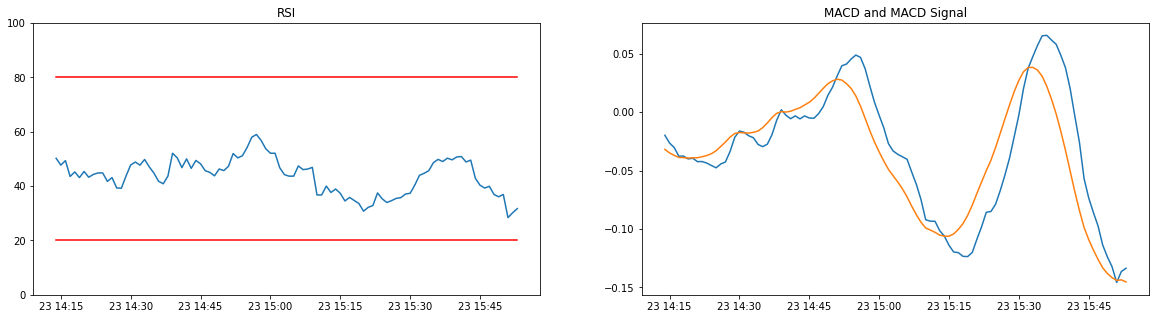

In [5]:
fig = plt.figure(figsize=(20, 5))
    
ax1 = plt.subplot2grid((1,2),(0,0))
labels = ['', '']
plt.plot(stock['time'][:100], stock['RSI'][:100])
plt.plot(stock['time'][:100], [20 for i in range(100)], color='r')
plt.plot(stock['time'][:100], [80 for i in range(100)], color='r')
plt.ylim(0, 100)
plt.title(f'RSI')
    
ax2 = plt.subplot2grid((1,2), (0, 1))
plt.plot(stock['time'][:100], stock['MACD'][:100])
plt.plot(stock['time'][:100], stock['MACD_Signal'][:100])
# plt.plot(stock['time'][:100], [20 for i in range(100)])
# plt.plot(stock['time'][:100], [80 for i in range(100)])
# plt.ylim(0, 100)
plt.title(f'MACD and MACD Signal')

---

# 3. BI LSTM Model

## 3.1. Scale and Reshape data

In [6]:
scaler = StandardScaler()

In [7]:
lstm_data = stock.copy()
lstm_data.head()

,time,open,high,low,close,volume,company,price_1_min_ahead,price_2_min_ahead,price_3_min_ahead,...,EMA,MACD,MACD_Signal,change,gain,loss,avg_gain,avg_loss,rs,RSI
0,2021-04-23 15:53:00,260.93,261.11,260.890,261.0000,105102,MSFT,260.93,261.18,261.05,...,261.146603,-0.133621,-0.145338,0.0700,0.07,0.0000,0.029490,0.063490,0.464483,31.716498
1,2021-04-23 15:52:00,260.81,260.98,260.810,260.9100,82132,MSFT,261.00,260.93,261.18,...,261.124069,-0.136377,-0.143545,-0.0900,0.00,0.0900,0.028015,0.064815,0.432235,30.179035
2,2021-04-23 15:51:00,261.05,261.17,260.800,260.8000,136199,MSFT,260.91,261.00,260.93,...,261.093205,-0.145757,-0.143988,-0.1100,0.00,0.1100,0.026615,0.067075,0.396792,28.407387
3,2021-04-23 15:50:00,261.01,261.09,261.005,261.0400,50257,MSFT,260.80,260.91,261.00,...,261.088138,-0.132300,-0.141650,0.2400,0.24,0.0000,0.037284,0.063721,0.585113,36.913021
4,2021-04-23 15:49:00,261.02,261.08,260.990,260.9946,56559,MSFT,261.04,260.80,260.91,...,261.079230,-0.123870,-0.138094,-0.0454,0.00,0.0454,0.035420,0.062805,0.563965,36.059951


In [8]:
X = lstm_data.copy()
X.drop(
    ['time', 'price_1_min_ahead', 'price_2_min_ahead', 'price_3_min_ahead', 'price_5_min_ahead', 'price_10_min_ahead', 'company', 'change', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs'],
    axis='columns',
    inplace=True
)
X.head()

,open,high,low,close,volume,SMA,up_band_1,up_band_2,up_band_3,low_band_1,low_band_2,low_band_3,EMA,MACD,MACD_Signal,RSI
0,260.93,261.11,260.890,261.0000,105102,261.110990,261.268152,261.425314,261.582476,260.953828,260.796666,260.639504,261.146603,-0.133621,-0.145338,31.716498
1,260.81,260.98,260.810,260.9100,82132,261.087490,261.237277,261.387063,261.536850,260.937703,260.787917,260.638130,261.124069,-0.136377,-0.143545,30.179035
2,261.05,261.17,260.800,260.8000,136199,261.053495,261.185650,261.317806,261.449961,260.921340,260.789184,260.657029,261.093205,-0.145757,-0.143988,28.407387
3,261.01,261.09,261.005,261.0400,50257,261.036495,261.144011,261.251526,261.359042,260.928979,260.821464,260.713948,261.088138,-0.132300,-0.141650,36.913021
4,261.02,261.08,260.990,260.9946,56559,261.023725,261.119020,261.214315,261.309610,260.928430,260.833135,260.737840,261.079230,-0.123870,-0.138094,36.059951


In [9]:
X_matrix = X.values
X_matrix.shape
X_matrix = scaler.fit_transform(X_matrix)

In [10]:
print("Before reshaping: ", X_matrix.shape)
X_matrix = X_matrix.reshape(X_matrix.shape[0], X_matrix.shape[1], 1)
print("After reshaping: ", X_matrix.shape)

Before reshaping:  (8718, 16)
After reshaping:  (8718, 16, 1)


In [11]:
y = np.array(lstm_data['price_1_min_ahead'])
print("Before reshaping: ", y.shape)
y = y.reshape(y.shape[0], 1)
print("After reshaping: ", y.shape)

Before reshaping:  (8718,)
After reshaping:  (8718, 1)


In [12]:
y = scaler.fit_transform(y)

## 3.2. Split to train and test set

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y, test_size=0.2, random_state=42)

## 3.3. Define and train model

In [14]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(16, 1)))
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16, 100)           40800     
_________________________________________________________________
bidirectional (Bidirectional (None, 16, 128)           84480     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 174,753
Trainable params: 174,753
Non-trainable params: 0
_________________________________________________________________


In [106]:
checkpoint = ModelCheckpoint("./SavedModels/BI_LSTM_best_model_1.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

model.fit(X_train, y_train, epochs=5, batch_size=1, callbacks=[checkpoint])

Epoch 1/5
 197/6974 [..............................] - ETA: 1:15 - loss: 0.4364

KeyboardInterrupt: 

## 3.4. Make and test predictions

In [16]:
# Upload a model if required
model = load_model('./SavedModels/BI_LSTM_best_model_1.h5')

In [17]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 16, 100)           40800     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 16, 128)           84480     
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 174,753
Trainable params: 174,753
Non-trainable params: 0
_________________________________________________________________


In [18]:
len(X_test)

1744

In [19]:
len(y_test)

1744

In [20]:
predictions = model.predict(X_test)

In [21]:
predictions

array([[ 1.0207591 ],
       [ 0.5705761 ],
       [-1.299134  ],
       ...,
       [ 0.39845788],
       [ 0.6511886 ],
       [ 0.64993817]], dtype=float32)

In [22]:
y_test

array([[ 1.07841127],
       [ 0.60253721],
       [-1.31903641],
       ...,
       [ 0.41412235],
       [ 0.68354329],
       [ 0.67875523]])

In [23]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 0.03458352711269221
Mean Squared Error: 0.0016666025362911472
Root Mean Squared Error: 0.04082404360534546


In [24]:
y_prices = scaler.inverse_transform(y_test)

In [25]:
y_prices

array([[260.81  ],
       [255.94  ],
       [236.275 ],
       ...,
       [254.0118],
       [256.769 ],
       [256.72  ]])

In [26]:
predictions_prices = scaler.inverse_transform(predictions)

In [27]:
predictions_prices

array([[260.22   ],
       [255.61292],
       [236.47868],
       ...,
       [253.85149],
       [256.4379 ],
       [256.42508]], dtype=float32)

In [28]:
print('ERROR VALUES FOR ACTUAL PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_prices, predictions_prices))
print('Mean Squared Error:', metrics.mean_squared_error(y_prices, predictions_prices))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_prices, predictions_prices)))

ERROR VALUES FOR ACTUAL PRICES
Mean Absolute Error: 0.3539209723516337
Mean Squared Error: 0.17454453082404636
Root Mean Squared Error: 0.4177852687973169


## 3.5. Performance in binary trading

In [29]:
X_pred = model.predict(X_matrix)
X_pred

array([[ 1.0212704],
       [ 1.0279839],
       [ 1.000201 ],
       ...,
       [-1.4354919],
       [-1.4290127],
       [-1.4272866]], dtype=float32)

In [30]:
X_pred_prices = scaler.inverse_transform(X_pred)
X_pred_prices

array([[260.22522],
       [260.29395],
       [260.0096 ],
       ...,
       [235.08322],
       [235.14952],
       [235.16719]], dtype=float32)

In [31]:
y

array([[ 1.09013712],
       [ 1.0969772 ],
       [ 1.08818282],
       ...,
       [-1.42408048],
       [-1.4768468 ],
       [-1.42310332]])

In [32]:
X_target_prices = scaler.inverse_transform(y)
X_target_prices

array([[260.93],
       [261.  ],
       [260.91],
       ...,
       [235.2 ],
       [234.66],
       [235.21]])

In [33]:
len(X_pred_prices)

8718

In [34]:
len(X_target_prices)

8718

In [35]:
len(stock['close'])

8718

In [36]:
def get_trades(actual_prices, target_prices):

    pred_labels = []
    for price in actual_prices - target_prices:
        # print(price)
        if price < 0:
            pred_labels.append(1)
        else:
            pred_labels.append(0)
    
    return pred_labels


In [37]:
X_pred_labels = get_trades(stock['close'], X_pred_prices.reshape(X_pred_prices.shape[0]))
X_target_labels = get_trades(stock['close'], X_target_prices.reshape(X_target_prices.shape[0]))

In [38]:
metrics.accuracy_score(X_pred_labels, X_target_labels)

0.5350997935306263

In [39]:
metrics.precision_score(X_pred_labels, X_target_labels, average=None)

array([0.73559322, 0.32844165])